In [1]:
import tensorflow as tf
import os
import time
import scipy
import numpy as np
import shutil
from tqdm import tqdm
from main import layers,load_vgg,optimize

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0
Tests Passed
Tests Passed
Tests Passed


In [2]:
image_shape = (160, 576)

def predict_using_raw_model(l_image_file):
    vgg_path = "./data/vgg/"
    num_classes = 2
    epochs = 50
    batch_size = 16
    tf.reset_default_graph()
    with tf.Session() as sess:
        correct_label = tf.placeholder(tf.int32, [None, None, None, num_classes])
        learning_rate = tf.placeholder(tf.float32)
    
        input_image, keep_prob, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = \
            load_vgg(sess, vgg_path)

        nn_last_layer = layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes)

        logits, training_op, cross_entropy_loss = \
            optimize(nn_last_layer, correct_label, learning_rate, num_classes)
        
        saver = tf.train.Saver()
        saver.restore(sess, "./models_l2_norm_lr00001_e100/eproch_90_loss_7867.2935")
        l_street_im = []
        for image_file in tqdm(l_image_file):
            image = scipy.misc.imresize(scipy.misc.imread(image_file), image_shape)
            im_softmax = sess.run(
                [tf.nn.softmax(logits)],
                {keep_prob: 1.0, input_image: [image]})
    
            im_softmax = im_softmax[0][:, 1].reshape(image_shape[0], image_shape[1])
            segmentation = (im_softmax > 0.5).reshape(image_shape[0], image_shape[1], 1)
            mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
            mask = scipy.misc.toimage(mask, mode="RGBA")
            street_im = scipy.misc.toimage(image)
            street_im.paste(mask, box=None, mask=mask)
            l_street_im.append(street_im)
    
    return l_street_im

INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'
INFO:tensorflow:Restoring parameters from ./models_l2_norm_lr00001_e100/eproch_90_loss_7867.2935


100%|██████████| 290/290 [00:43<00:00,  7.78it/s]


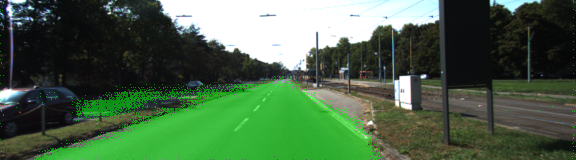

In [3]:
image_file = "./data/data_road/testing/image_2/um_000052.png"
l_input_images = !ls ./data/data_road/testing/image_2/*png
l_img = predict_using_raw_model(l_input_images)
l_img[0]

In [4]:
def load_graph(graph_file, use_xla=False):
    jit_level = 0
    config = tf.ConfigProto()
    if use_xla:
        jit_level = tf.OptimizerOptions.ON_2
        config.graph_options.optimizer_options.global_jit_level = jit_level

    with tf.Session(graph=tf.Graph(), config=config) as sess:
        gd = tf.GraphDef()
        with tf.gfile.Open(graph_file, 'rb') as f:
            data = f.read()
            gd.ParseFromString(data)

        tf.import_graph_def(gd, name='')
        ops = sess.graph.get_operations()
        n_ops = len(ops)
        return sess, ops
    
def predict_using_graphdef_file(l_image_file, graph_file, use_xla=False):
    sess, _ = load_graph(graph_file, use_xla)
    graph = sess.graph
    image_input = graph.get_tensor_by_name("image_input:0")
    keep_prob   = graph.get_tensor_by_name("keep_prob:0")
    logit       = graph.get_tensor_by_name("predicted_label:0")
    l_street_im = []
    for image_file in tqdm(l_image_file):
        image = scipy.misc.imresize(scipy.misc.imread(image_file), image_shape)
        im_softmax = sess.run(
            [logit],
            {keep_prob: 1.0, image_input: np.expand_dims(image, axis=0)})
        
        im_softmax = im_softmax[0][:, 1].reshape(image_shape[0], image_shape[1])
        segmentation = (im_softmax > 0.5).reshape(image_shape[0], image_shape[1], 1)
        mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
        mask = scipy.misc.toimage(mask, mode="RGBA")
        street_im = scipy.misc.toimage(image)
        street_im.paste(mask, box=None, mask=mask)
        l_street_im.append(street_im)
    
    return l_street_im
    

## Using some optimization

The optimized model ran faster, but the result seemed not so well as the origin model.

100%|██████████| 290/290 [00:30<00:00, 10.43it/s]


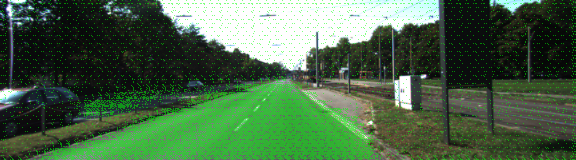

In [5]:
l_img = predict_using_graphdef_file(l_input_images, graph_file="./freezed_model/frozen_graph.pb")
l_img[0]

100%|██████████| 290/290 [00:29<00:00,  9.27it/s]


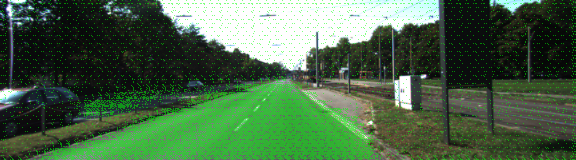

In [6]:
l_img = predict_using_graphdef_file(l_input_images, graph_file="./freezed_model/optimized_graph.pb")
l_img[0]

## One problem

8bit much slower. This has been reported as an issue on tensorflow github [https://github.com/tensorflow/tensorflow/issues/5757](https://github.com/tensorflow/tensorflow/issues/5757). 

In [ ]:
l_img = predict_using_graphdef_file(l_input_images[0:3], graph_file="./freezed_model/eightbit_graph.pb")
l_img[0]

In [ ]:
l_img = predict_using_graphdef_file(l_input_images[0:3], graph_file="./freezed_model/eightbit_graph.pb", use_xla=True)
l_img[0]

# Test on a video

In [8]:
#import imageio
#imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip

In [19]:
class UsingFcnOnVideo(object):
    def __init__(self, graph_file, use_xla=False, image_shape=[160, 576]):
        self.model = graph_file
        self.sess, _ = load_graph(graph_file, use_xla)
        self.image_shape = image_shape
        graph = self.sess.graph
        self.image_input = graph.get_tensor_by_name("image_input:0")
        self.keep_prob   = graph.get_tensor_by_name("keep_prob:0")
        self.logit       = graph.get_tensor_by_name("predicted_label:0")
        
    def process_image(self, image):
        image = scipy.misc.imresize(image, self.image_shape)
        im_softmax = self.sess.run(
            [self.logit],
            {self.keep_prob: 1.0, self.image_input: np.expand_dims(image, axis=0)})
        
        im_softmax = im_softmax[0][:, 1].reshape(self.image_shape[0], self.image_shape[1])
        segmentation = (im_softmax > 0.5).reshape(self.image_shape[0], self.image_shape[1], 1)
        mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
        mask = scipy.misc.toimage(mask, mode="RGBA")
        street_im = scipy.misc.toimage(image)
        street_im.paste(mask, box=None, mask=mask)
        return np.array(street_im, dtype="uint8")
        

In [20]:
m_video = UsingFcnOnVideo("./freezed_model/frozen_graph.pb")

In [25]:
clip = VideoFileClip("../../Project4_AdvancedLaneLines/CarND-Advanced-Lane-Lines/project_video.mp4")
proj_clip = clip.fl_image(m_video.process_image)
%time proj_clip.write_videofile("./project_video.result.mp4", audio=False)

[MoviePy] >>>> Building video ./project_video.result.mp4
[MoviePy] Writing video ./project_video.result.mp4


100%|█████████▉| 1260/1261 [01:45<00:00, 11.93it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video.result.mp4 

CPU times: user 1min 32s, sys: 17.1 s, total: 1min 49s
Wall time: 1min 45s


In [ ]:
clip = VideoFileClip("../../Project4_AdvancedLaneLines/CarND-Advanced-Lane-Lines/challenge_video.mp4")
proj_clip = clip.fl_image(m_video.process_image)
%time proj_clip.write_videofile("./challenge_video.result.mp4", audio=False)

In [23]:
clip = VideoFileClip("../../Project4_AdvancedLaneLines/CarND-Advanced-Lane-Lines/harder_challenge_video.mp4")
proj_clip = clip.fl_image(m_video.process_image)
%time proj_clip.write_videofile("./harder_challenge_video.result.mp4", audio=False)

[MoviePy] >>>> Building video ./harder_challenge_video.result.mp4
[MoviePy] Writing video ./harder_challenge_video.result.mp4


100%|█████████▉| 1199/1200 [01:43<00:00, 11.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./harder_challenge_video.result.mp4 

CPU times: user 1min 33s, sys: 15.3 s, total: 1min 48s
Wall time: 1min 43s


In [26]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format("./project_video.result.mp4"))